In [1]:
# importer les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import LabelEncoder  # permet de remplacer des valeurs par des 0, 1, 2, ...
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score # permet de calculer la performance
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
gender_submission = pd.read_csv('/content/gender_submission.csv')
gender_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [3]:
train = pd.read_csv('/content/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# afficher les valeurs numerics pour verifier s'il ya des valeurs anormales
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# divide the dataframe into numeric_train and category_train
def num_category_df(df):
  numeric_train = []
  category_train = []

  for index, typ in enumerate(df.dtypes):
    if typ == 'object':
      category_train.append(df.iloc[:,index])
    else:
      numeric_train.append(df.iloc[:,index])
  return numeric_train, category_train

# make the list in dataframe
numeric_train, category_train = num_category_df(train)
numeric_train = pd.DataFrame(numeric_train)
category_train = pd.DataFrame(category_train)
numeric_train= numeric_train.transpose()
category_train= category_train.transpose()
# category_train
numeric_train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500
...,...,...,...,...,...,...,...
886,887.0,0.0,2.0,27.0,0.0,0.0,13.0000
887,888.0,1.0,1.0,19.0,0.0,0.0,30.0000
888,889.0,0.0,3.0,NaN,1.0,2.0,23.4500
889,890.0,1.0,1.0,26.0,0.0,0.0,30.0000


In [7]:
# fill nan values of category_train with the most frequence values
category_train = category_train.apply(lambda x:x.fillna(x.value_counts().index[0]))
category_train.isnull().sum().sort_values()

Name        0
Sex         0
Ticket      0
Cabin       0
Embarked    0
dtype: int64

In [8]:
# fill nan values of numeric train with mean values
numeric_train = numeric_train.apply(lambda x:x.fillna(x.mean()))
numeric_train.isnull().sum().sort_values()

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

In [9]:
le = LabelEncoder()
# transformer toutes les valeurs de category_train avec 'le' en numerique
for i in category_train:
  category_train[i] = le.fit_transform(category_train[i])

# concatenate numeric_train and category_train
train_no_null = pd.concat([numeric_train, category_train], axis=1)
train_no_null

# category_train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500,108,1,523,145,2
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833,190,0,596,81,0
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250,353,0,669,145,2
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000,272,0,49,55,2
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500,15,1,472,145,2
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887.0,0.0,2.0,27.000000,0.0,0.0,13.0000,548,1,101,145,2
887,888.0,1.0,1.0,19.000000,0.0,0.0,30.0000,303,0,14,30,2
888,889.0,0.0,3.0,29.699118,1.0,2.0,23.4500,413,0,675,145,2
889,890.0,1.0,1.0,26.000000,0.0,0.0,30.0000,81,1,8,60,0


In [10]:
# drop colomn Name and Ticket
drop_col =['Name','Ticket']
train_no_null = train_no_null.drop(drop_col, axis=1)
train_no_null

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Cabin,Embarked
0,1.0,0.0,3.0,22.000000,1.0,0.0,7.2500,1,145,2
1,2.0,1.0,1.0,38.000000,1.0,0.0,71.2833,0,81,0
2,3.0,1.0,3.0,26.000000,0.0,0.0,7.9250,0,145,2
3,4.0,1.0,1.0,35.000000,1.0,0.0,53.1000,0,55,2
4,5.0,0.0,3.0,35.000000,0.0,0.0,8.0500,1,145,2
...,...,...,...,...,...,...,...,...,...,...
886,887.0,0.0,2.0,27.000000,0.0,0.0,13.0000,1,145,2
887,888.0,1.0,1.0,19.000000,0.0,0.0,30.0000,0,30,2
888,889.0,0.0,3.0,29.699118,1.0,2.0,23.4500,0,145,2
889,890.0,1.0,1.0,26.000000,0.0,0.0,30.0000,1,60,0


In [11]:
target = train_no_null['Survived']

all_features = train_no_null.columns.tolist()
all_features.remove('Survived')
all_features.remove('PassengerId')
all_features.remove('Cabin')
all_features.remove('Fare')
all_features.remove('Embarked')

X = train_no_null[all_features]
y = target

all_features

['Pclass', 'Age', 'SibSp', 'Parch', 'Sex']

le pourcentage de mort est:0.62
le pourcentage de survivant est:0.38


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Visualisation de la variable cible')

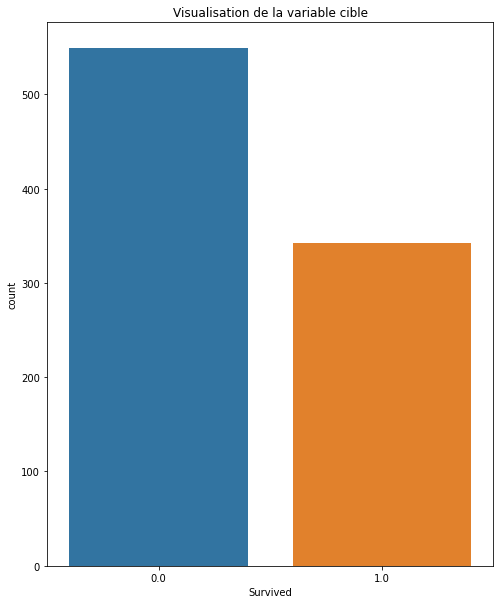

In [12]:
# display survived pourcentage
fig = plt.figure(figsize=(8,10))
sbn.countplot(target)
# dead and alive pourcentage
dead = target.value_counts()[0] /len(target)
alive = target.value_counts()[1] /len(target)
print(f"le pourcentage de mort est:{round(dead, 2)}")
print(f"le pourcentage de survivant est:{round(alive, 2)}")
plt.title('Visualisation de la variable cible')


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


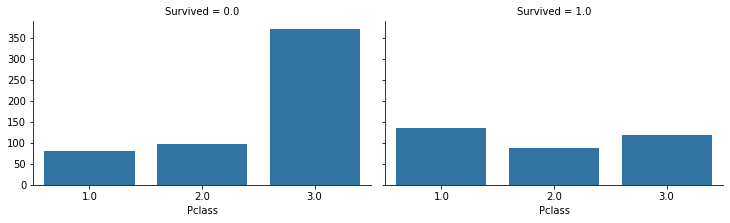

In [13]:
# Visualisation des survivants selon Pclass: conatat= beaucoup de mort de la class 3
grid= sbn.FacetGrid(train_no_null,col='Survived', size=3.2, aspect=1.6)
grid.map(sbn.countplot, 'Pclass')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


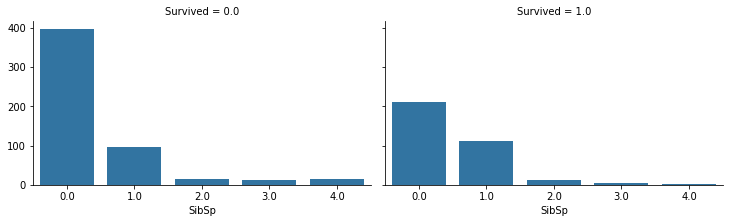

In [14]:
# Visualisation des survivants selon Embarked: conatat=
grid= sbn.FacetGrid(train_no_null,col='Survived', size=3.2, aspect=1.6)
grid.map(sbn.countplot, 'SibSp')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


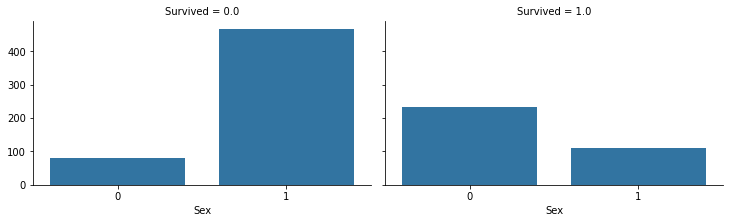

In [15]:
grid= sbn.FacetGrid(train_no_null,col='Survived', size=3.2, aspect=1.6)
grid.map(sbn.countplot, 'Sex')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


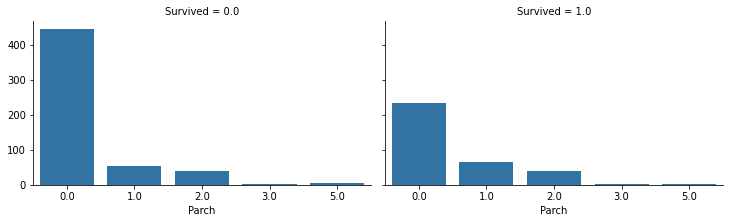

In [16]:
grid= sbn.FacetGrid(train_no_null,col='Survived', size=3.2, aspect=1.6)
grid.map(sbn.countplot, 'Parch')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


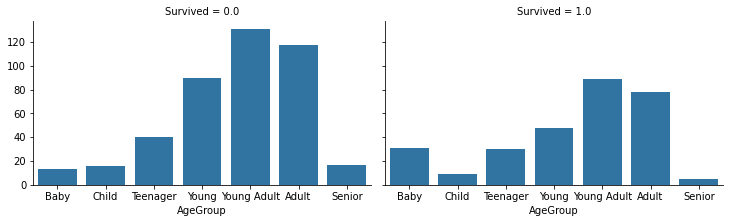

In [18]:
bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teenager', 'Young', 'Young Adult', 'Adult', 'Senior']
train_no_null['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
grid= sbn.FacetGrid(train_no_null,col='Survived', size=3.2, aspect=1.6)
grid.map(sbn.countplot, 'AgeGroup')

In [19]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
for train, test in sss.split(X,y):
  X_train, X_test =X.iloc[train], X.iloc[test]
  y_train, y_test = y.iloc[train], y.iloc[test]
print('taille de X_train: ', X_train.shape)
print('taille de X_test: ', X_test.shape)
print('taille de y_train: ', y_train.shape)
print('taille de y_test: ', y_test.shape)

taille de X_train:  (712, 5)
taille de X_test:  (179, 5)
taille de y_train:  (712,)
taille de y_test:  (179,)


In [20]:
# algerithme choisi: logistic Regression, KNN, DecisionTree

models={'LogisticRegression': LogisticRegression(random_state=50, solver='liblinear'),
        'KNeighborsClassifier': KNeighborsClassifier(),
        'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=1, random_state=50)
}
# fonction de precision: permet d'evaluer la performance d'une model
def accu(y_true, y_pred, retu=False):
  acc = accuracy_score(y_true, y_pred)
  if retu:
    return acc
  else:
    print(f"la performance du model est de {round(acc, 2)}")

# fonction entrainement et prediction, evaluation des performances
def train_test_evaluate(X_train, X_test, y_train, y_test, models):
  for name, model in models.items():
    print(name,':')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accu(y_test, predictions)
    print('-'*30) # pour la separation

train_test_evaluate(X_train, X_test, y_train, y_test, models)

LogisticRegression :
la performance du model est de 0.8
------------------------------
KNeighborsClassifier :
la performance du model est de 0.8
------------------------------
DecisionTreeClassifier :
la performance du model est de 0.8
------------------------------


In [21]:
test = pd.read_csv('/content/test.csv')
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


#Traitement du dataframe test

In [22]:
numeric_test, category_test = num_category_df(test)

numeric_test = pd.DataFrame(numeric_test)
category_test = pd.DataFrame(category_test)

numeric_test= numeric_test.transpose()
category_test= category_test.transpose()
numeric_test
# category_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,892.0,3.0,34.5,0.0,0.0,7.8292
1,893.0,3.0,47.0,1.0,0.0,7.0000
2,894.0,2.0,62.0,0.0,0.0,9.6875
3,895.0,3.0,27.0,0.0,0.0,8.6625
4,896.0,3.0,22.0,1.0,1.0,12.2875
...,...,...,...,...,...,...
413,1305.0,3.0,NaN,0.0,0.0,8.0500
414,1306.0,1.0,39.0,0.0,0.0,108.9000
415,1307.0,3.0,38.5,0.0,0.0,7.2500
416,1308.0,3.0,NaN,0.0,0.0,8.0500


In [23]:
category_test = category_test.apply(lambda x:x.fillna(x.value_counts().index[0]))
category_test.isnull().sum().sort_values()

Name        0
Sex         0
Ticket      0
Cabin       0
Embarked    0
dtype: int64

In [24]:
numeric_test = numeric_test.apply(lambda x:x.fillna(x.mean()))
numeric_test.isnull().sum().sort_values()

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

In [ ]:
le = LabelEncoder()
# transformer toutes les valeur de category_test avec 'le' en numeric
for i in category_test:
  category_test[i] = le.fit_transform(category_test[i])

# concatenate numeric_test and category_test
test_no_null = pd.concat([numeric_test, category_test], axis=1)
# test_no_null

# drop colomn Name and Ticket
test_no_null = test_no_null.drop(drop_col, axis=1)
test_no_null


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Cabin,Embarked
0,892.0,3.0,34.50000,0.0,0.0,7.8292,1,15,1
1,893.0,3.0,47.00000,1.0,0.0,7.0000,0,15,2
2,894.0,2.0,62.00000,0.0,0.0,9.6875,1,15,1
3,895.0,3.0,27.00000,0.0,0.0,8.6625,1,15,2
4,896.0,3.0,22.00000,1.0,1.0,12.2875,0,15,2
...,...,...,...,...,...,...,...,...,...
413,1305.0,3.0,30.27259,0.0,0.0,8.0500,1,15,2
414,1306.0,1.0,39.00000,0.0,0.0,108.9000,0,22,0
415,1307.0,3.0,38.50000,0.0,0.0,7.2500,1,15,2
416,1308.0,3.0,30.27259,0.0,0.0,8.0500,1,15,2


#Prediction par Modele

In [ ]:

# log_R_model = LogisticRegression(random_state=20, solver='liblinear')

# log_R_model.fit(X,y)
# # predictions
# predictions= log_R_model.predict(test_no_null[all_features])

# len(predictions)
# predictions.astype('int')


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
# # KNN
# knn = KNeighborsClassifier()

# knn.fit(X,y)
# # predictions
# predictions= knn.predict(test_no_null[all_features])

# len(predictions)
# predictions.astype('int')

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,

In [ ]:
# DecissionTree
dt = DecisionTreeClassifier(max_depth=1, random_state=50)
dt.fit(X,y)
# predictions
predictions= dt.predict(test_no_null[all_features])

len(predictions)
predictions.astype('int')


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
# final test dataset
test['Survived'] = predictions.astype('int')
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [ ]:
# Create Soubmission dataframe
akreacho_submission = test[['PassengerId', 'Survived']]
akreacho_submission = pd.DataFrame(akreacho_submission)
akreacho_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
# Soubmission file to CSV
akreacho_submission.to_csv('akreacho_submission.csv', index = False)